# CSCE 421 Final Project

Jeffrey Xu  
Prof. Mortazavi  
CSCE 421  
11/11/2020  

## Abstract
Image classification has been an interesting field within AI and machine learning for many years now. There are many different machine learning models that can perform the task of image classification. Finding the best model however can be quite tricky as different models have different strengths and weaknesses. We explore the effectiveness of some unique machine learning models that can perform image classification and analyze the performance of each model on the MNIST digit dataset. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

We start by making sure the versions of our imports are correct. We can do this by using pip. 

In [40]:
!pip install torchvision==0.2.1
!pip install scikit-learn==0.23.2

Now we import all the required libraries for this project. 

In [56]:
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import pandas as pd

We also set some initial hyperparameters. These values can change depending on how we want to implement our models. 

In [4]:
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument("-f")
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--nrow', type=int, default=5,
                    help='rows of example')
parser.add_argument('--ncol', type=int, default=10,
                    help='columns of example')

args = parser.parse_args()

torch.manual_seed(args.seed)

Now we load in the training datasets that we are going to use for this project. 

In [5]:
imbalanced_linear_train_dataset = torch.load('imbalanced_linear_train_dataset.pt')
imbalanced_linear_train_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset,
                                                             batch_size=args.batch_size, shuffle=True)

imbalanced_step_train_dataset = torch.load('imbalanced_step_train_dataset.pt')
imbalanced_step_train_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size,
                                                           shuffle=True)

In [6]:
X_linear = []
y_linear = []

for data in imbalanced_linear_train_dataset:
    X_linear.append(np.array(data[0]).flatten())
    y_linear.append(int(data[1]))
    
X_linear = np.array(X_linear)
y_linear = np.array(y_linear)

In [7]:
X_step = []
y_step = []

for data in imbalanced_step_train_dataset:
    X_step.append(np.array(data[0]).flatten())
    y_step.append(int(data[1]))
    
X_step = np.array(X_linear)
y_step = np.array(y_step)

Now we load in the testing datasets for this project. 

In [8]:
test_dataset = torch.load('test_dataset.pt')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True)

In [122]:
X_test = []
y_test = []

for data in test_dataset:
    X_test.append(np.array(data[0]).flatten())
    y_test.append(int(data[1]))
    
X_test = np.array(X_test)
y_test = np.array(y_test)

We define a function that shows the distribution of the MNIST dataset. 

In [10]:
def show_mnist(arr, nrow=args.nrow, ncol=args.ncol, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('examples.png')

Here, we display the distribution of our MNIST dataset. 

Distribution of classes in linear imbalanced dataset:


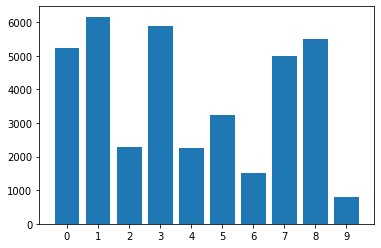

In [11]:
print('Distribution of classes in linear imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_linear_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist linear.png')
plt.show()

Distribution of classes in step imbalanced dataset:


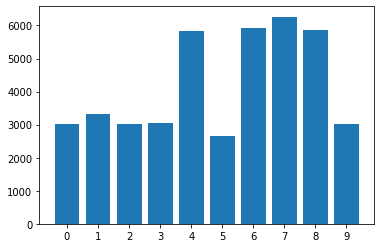

In [12]:
print('Distribution of classes in step imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_step_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist step.png')
plt.show()

Below, we show the numbers used in each dataset. 

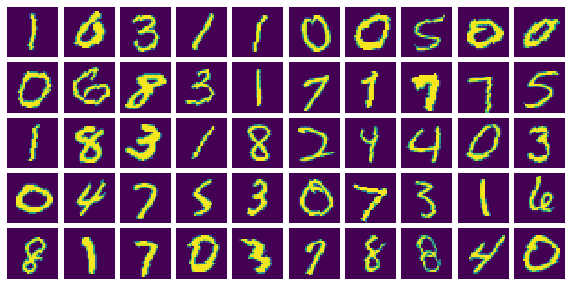

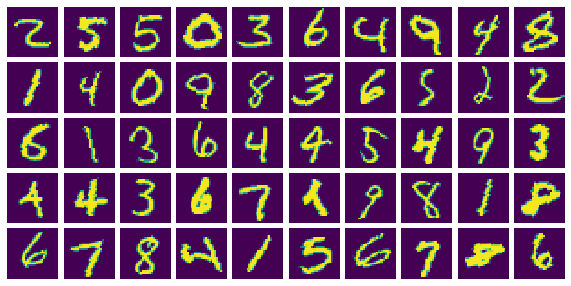

In [13]:
for data, _ in imbalanced_linear_train_loader:
    show_mnist(data)
    break

for data, _ in imbalanced_step_train_loader:
    show_mnist(data)
    break

## Logistic Regression
Our first model to test on this MNIST dataset is logistic regression. We start by importing the model in from *sklearn*.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

We will also perform Cross Validation on the training data to determine the best hyperparameters to use for our logistical model here. We also need to implement a multiclass roc score function to accurately test how well our model is doing despite the imbalance of the given dataset. 

In [112]:
def roc_auc_score_multiclass(actual_class, pred_class, average="macro"):
    # Creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        # Creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        # Marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    # Computing the average roc auc score
    total = 0
    for item in roc_auc_dict.values():
        total += item
        
    return total/len(roc_auc_dict.values())

def max_val(d):
    max = 0
    max_element = 0
    for item in d.keys():
        if d[item] > max:
            max = d[item]
            max_element = item
    return max_element

In [103]:
num_folds = 5
c_vals = [100, 10, 1.0, 0.1, 0.01]
auc_dict = {100:0, 10:0, 1.0:0, 0.1:0, 0.01:0}
count = 1

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for train_index, test_index in skf.split(X_linear, y_linear):
    x_train, x_test = pd.DataFrame(X_linear).iloc[train_index], pd.DataFrame(X_linear).iloc[test_index]
    Y_train, Y_test = pd.DataFrame(y_linear).iloc[train_index], pd.DataFrame(y_linear).iloc[test_index]
    
    for c in c_vals:
        log_regressor = LogisticRegression(solver="lbfgs", C=c)
        log_regressor.fit(x_train, Y_train)
        
        pred = log_regressor.predict(x_test)
        auc_dict[c] += roc_auc_score_multiclass(np.array(Y_test).T[0], pred) / 5
    print("Fold " + str(count) + " completed")
    count += 1

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed


In [114]:
print("Best C value: " + str(max_val(auc_dict)))

Best C value: 0.1


Now we fit our Logistic Regression model to our data. 

In [115]:
log_model = LogisticRegression(solver="lbfgs", C=max_val(auc_dict)).fit(X_linear, y_linear)

In [116]:
pred = log_model.predict(X_test)

In [126]:
print("AUC ROC multiclass score for linear dataset: " + str(roc_auc_score_multiclass(y_test, pred)))

AUC ROC multiclass score for linear dataset: 0.9395921430863332
